In [1]:
model_code = "pretrain_thai2vec_no_dropout"
f_log_dir = "./"+model_code+"_log"
f_log_dir_train = "./"+model_code+"_log/training/"
f_log_dir_val = "./"+model_code+"_log/validate/"
f_chkpt_h5 = model_code+"_model"+".h5"
f_model_json = model_code+"_model_json"+".json"
f_model_weights = model_code+"_model_weights"+".h5"
f_infer_all = model_code+"_model_infer"+".txt"
f_model_png = model_code+"_model_image"+".png"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pythainlp.tokenize import word_tokenize
from gensim.models import KeyedVectors
from itertools import cycle
from scipy import interp
from collections import Counter
from pprint import pprint

import dill as pickle
import numpy as np
import pandas as pd
import io
import sys
import graphviz
import pydot

#matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

#keras
import keras.models
from keras.models import Sequential
from keras.layers import Dense, AveragePooling1D, Bidirectional
from keras.layers import LSTM, Convolution1D, Flatten, Dropout, Conv1D, GRU
from keras.layers import SpatialDropout1D, MaxPooling1D, TimeDistributed 
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras import losses
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import load_model

#sklearn
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets

#more

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import tensorflow as tf

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = f_log_dir_train #os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = f_log_dir_val #os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [4]:
# updatable plot
# a minimal example (sort of)
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()


In [5]:
#Thai2Vec Pre-trained Word Embedding
def sentence_vectorizer(s,model,dim=300,use_mean=False):
    #s = word_tokenize(ss)
    vec = np.zeros((1,dim))
    for word in s:
        if word in model.wv.index2word:
            vec+= model.wv.word_vec(word)
        else: pass
    if use_mean: vec /= len(s)
    return(vec)

#load into gensim
thai2vec_model = KeyedVectors.load_word2vec_format('thai2vec.vec',binary=False)

#create dataframe
thai2dict = {}
for word in thai2vec_model.index2word:
    thai2dict[word] = thai2vec_model[word]
thai2vec = pd.DataFrame.from_dict(thai2dict,orient='index')
#thai2vec.head()
print(len(thai2vec))
#thai2dict['เงิน']

51358


In [6]:
#Our Train/Test/Validate Data
data_text = pd.read_csv('SentiFine_deepcut_raw_text_only_copy.txt', header=None, encoding="UTF-8", names = ["Text"])
data_label = pd.read_csv('SentiFine_raw_label_only.txt', header=None, encoding="UTF-8", names = ["Sentiment"])
data_temp = pd.DataFrame({'text': data_text['Text'],
                    'sentiment': data_label['Sentiment']})

for index in range(len(data_temp)):
    sentence = data_temp['text'][index]
    data_temp['text'][index] = sentence.replace(" ", "")
                    
data_temp.head()
data_temp.describe()

sentiment                                      text
count       9352                                      9352
unique         3                                      7292
top     positive  ราคาทองคำแท่งซื้อบาทขายบาทเปลี่ยนแปลงบาท
freq        4349                                        80

In [7]:
data_thai2vec = []

for index in range(len(data_temp)):
    sentence = data_temp['text'][index]
    data_thai2vec.append(sentence_vectorizer(data_temp['text'][index],thai2vec_model,dim=300,use_mean=False))
                    
print(len(data_thai2vec))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


9352


In [8]:
#Decode Label from text to Int
temp_sentiment_int = []
for index in range(len(data_temp)):
    if data_label['Sentiment'][index] == 'neutral':
        temp_sentiment_int.append(0)
    elif data_label['Sentiment'][index] == 'negative':
        temp_sentiment_int.append(1)
    elif data_label['Sentiment'][index] == 'positive':
        temp_sentiment_int.append(2)        
    else:
        temp_sentiment_int.append("?")

In [9]:
data_prep = pd.DataFrame({'Text': data_text['Text'],
                     'Text1': data_temp['text'],
                    'Sentiment': data_label['Sentiment'],
                     'Sentiment_int': temp_sentiment_int
                    })
data_prep.tail()

Sentiment  Sentiment_int  \
9347  positive              2   
9348  positive              2   
9349  positive              2   
9350  positive              2   
9351  negative              1   

                                                   Text  \
9347  หุ้น ไทย เช้า นี้ ปิด บวก   อยู่ ที่   รับแรง ...   
9348  SET   เช้า ปิด ที่   +   มูลค่า การ ซื้อขาย   ...   
9349  ข้อมูล การ ผลิต แกร่ง   ส่ง หุ้น สหรัฐปิด บวก ...   
9350  ราคา ทองคำ แท่ง วัน อังคาร ที่   ก.ค.   ครั้ง ...   
9351  ราคา ทอง หลุดบาท ละบ.   ฉุด ผล ตอบแทน กองทองวู...   

                                                  Text1  
9347  หุ้นไทยเช้านี้ปิดบวกอยู่ที่รับแรงซื้อหุ้นขนาดใ...  
9348              SETเช้าปิดที่+มูลค่าการซื้อขายล้านบาท  
9349              ข้อมูลการผลิตแกร่งส่งหุ้นสหรัฐปิดบวก   
9350  ราคาทองคำแท่งวันอังคารที่ก.ค.ครั้งที่เวลาน.+ร้...  
9351            ราคาทองหลุดบาทละบ.ฉุดผลตอบแทนกองทองวูบ

In [10]:
thai2vec_vocab = pd.read_csv('thai2vec.vocab', header=None, sep= " ", encoding="UTF-8", names = ["Text", "Key"])
thai2vec_vocab.tail()

Text  Key
51353       ไลต์ฟ    5
51354      ไหนว่า    4
51355      ไอซ์ที    3
51356  ไอบูโปรเฟน    2
51357      ไออุ่น    1

In [11]:
my_dict_to_int = thai2vec_vocab.set_index('Text')['Key'].to_dict()
int_to_mydict = thai2vec_vocab.set_index('Key')['Text'].to_dict()

In [12]:
r = thai2vec_vocab['Text']
all_text = ' '.join(str(r))
wo = all_text.split()
wo_counts = Counter(wo)
vocab = sorted(wo_counts, key=wo_counts.get, reverse=True)

In [13]:
print(my_dict_to_int['ไออุ่น'])
print(int_to_mydict[1])

1
ไออุ่น


In [14]:
#for index, row in data_prep.iterrows():

data_ints = []
i_count = 0
for index, row in data_prep.iterrows():
    temp_ints = []
    for word in row['Text'].split():
        #print(vocab_to_int[word])
        if my_dict_to_int.get(word, 0) != 0:
            temp_ints.append(my_dict_to_int[word])
    data_ints.append(temp_ints)
    i_count = i_count + 1

len(data_ints)

9352

In [15]:
data = pd.DataFrame({'Text': data_prep['Text'],
                         'Text1': data_prep['Text1'],
                     'Sentiment': data_prep['Sentiment'],
                     'Sentiment_int': data_prep['Sentiment_int'],
                          'Text_int': data_ints
                    })
data.tail()

Sentiment  Sentiment_int  \
9347  positive              2   
9348  positive              2   
9349  positive              2   
9350  positive              2   
9351  negative              1   

                                                   Text  \
9347  หุ้น ไทย เช้า นี้ ปิด บวก   อยู่ ที่   รับแรง ...   
9348  SET   เช้า ปิด ที่   +   มูลค่า การ ซื้อขาย   ...   
9349  ข้อมูล การ ผลิต แกร่ง   ส่ง หุ้น สหรัฐปิด บวก ...   
9350  ราคา ทองคำ แท่ง วัน อังคาร ที่   ก.ค.   ครั้ง ...   
9351  ราคา ทอง หลุดบาท ละบ.   ฉุด ผล ตอบแทน กองทองวู...   

                                                  Text1  \
9347  หุ้นไทยเช้านี้ปิดบวกอยู่ที่รับแรงซื้อหุ้นขนาดใ...   
9348              SETเช้าปิดที่+มูลค่าการซื้อขายล้านบาท   
9349              ข้อมูลการผลิตแกร่งส่งหุ้นสหรัฐปิดบวก    
9350  ราคาทองคำแท่งวันอังคารที่ก.ค.ครั้งที่เวลาน.+ร้...   
9351            ราคาทองหลุดบาทละบ.ฉุดผลตอบแทนกองทองวูบ    

                                               Text_int  
9347  [47795, 51273, 48000, 51323, 50289, 49199, 513...  
9348  [48000, 50289, 51358, 49682, 48809, 51351, 446...  
9349  [51018, 51351, 50893, 40620, 51057, 47795, 49199]  
9350  [49794, 49679, 47693, 51230, 48213, 51358, 418...  
9351                [49794, 50993, 37770, 50988, 41449]

In [16]:
#print(embedding_matrix[1])

In [17]:
#print(thai2dict['ที่'])

In [18]:
embedding_dim = 300
embedding_matrix = np.zeros((51556, embedding_dim))

for index, row in thai2vec_vocab.iterrows():
    #if index < 51556:
        #print(index)
        #print(row['Text'])
        try:
            embedding_vector = thai2dict[str(row['Text'])]
            if embedding_vector is not None:
                embedding_matrix[row['Key']] = embedding_vector
        except KeyError:
            continue
        #print(embedding_vector)


In [19]:
#Define some static parameters of model

# Embedding
max_features = 20000
maxlen = 300
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 30

In [20]:
#Build Up X & Y for the Sequential Model

X = data['Text_int']
X = pad_sequences(X, maxlen = maxlen)

Y = pd.get_dummies(data['Sentiment'], columns=['negative','neural','positive']).values

#Split data to 2 parts: 1. XX&YY = train&test set  2. X_val&Y_val = validate set
XX, X_val, YY, Y_val = train_test_split(X,Y, test_size = 0.20, random_state = 42)

In [21]:
#Overall Data Summary 
print('No. of negative, neutral, positive in dataset:')
print(data[ data['Sentiment'] == 'negative'].size, data[ data['Sentiment'] == 'neutral'].size, data[ data['Sentiment'] == 'positive'].size)

print('Shape of XX&YY train&test data set:')
print(XX.shape,YY.shape)

print('Shape of X&Y validate data set:')
print(X_val.shape,Y_val.shape)

No. of negative, neutral, positive in dataset:
19055 5960 21745
Shape of XX&YY train&test data set:
(7481, 300) (7481, 3)
Shape of X&Y validate data set:
(1871, 300) (1871, 3)


In [22]:
#Build model

model = Sequential()
model.add(Embedding(51556, 300, input_length=maxlen, weights=[embedding_matrix], trainable=True))
# model.add(Dropout(0.25))

model.add(Conv1D(64, kernel_size, activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size))
# model.add(Dropout(0.25))

model.add(Conv1D(64, 1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
# model.add(Dropout(0.25))

model.add(Bidirectional(GRU(16, return_sequences=True)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adamax',metrics = ['accuracy'])

print(model.summary())

# #model.add(Dropout(0.5))

# model.add(Conv1D(64, kernel_size, activation='relu'))
# model.add(MaxPooling1D(pool_size=pool_size))
# #model.add(Dropout(0.5))

# model.add(Conv1D(64, 1, activation='relu'))
# model.add(MaxPooling1D(pool_size=1))
# #model.add(Dropout(0.5))

# model.add(Bidirectional(GRU(32, return_sequences=True)))
# #model.add(Dropout(0.5))
# model.add(Bidirectional(GRU(16, return_sequences=True)))
# #model.add(Dropout(0.5))

# model.add(Flatten())
# model.add(Dense(16, activation='relu'))

# #model.add(Dropout(0.5))
# model.add(Dense(3,activation='softmax'))

# optimizer = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
# model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])

# print(model.summary())
#plot_model(model, to_file=f_model_png)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          15466800  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 64)           96064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 74, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 74, 64)            4160      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 74, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 74, 32)            7776      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2368)              0         
__________

In [23]:
#Start training
#tensorBoardCallback = TensorBoard(log_dir=f_log_dir,histogram_freq=2,  write_graph=True)
checkpointer = ModelCheckpoint(filepath=f_chkpt_h5, verbose=1, save_best_only=True)

#No. of K-fold
k = 5
l = int(len(XX) / k)
#print(l)
mse_total, mae_total = 0, 0
for i in range(k):
    X_train = XX[i*l:(i+1)*l]
    Y_train = YY[i*l:(i+1)*l]

    X_test = np.concatenate([XX[:i*l], XX[(i+1)*l:]]);
    Y_test = np.concatenate([YY[:i*l], YY[(i+1)*l:]]);
    
    #print(X_train.shape, Y_train.shape)
    #print(X_test.shape, Y_test.shape)
    
    #model.fit(train_x, train_y, epochs=15)
    history = model.fit(X_train, Y_train, 
              batch_size=batch_size, 
              epochs=epochs,
              shuffle=True, 
              #callbacks=[checkpointer,tensorBoardCallback,plot_losses],
              callbacks=[checkpointer,TrainValTensorBoard(write_graph=False)],
              validation_data=(X_test, Y_test))

    #predictions = model.predict(test_x)
    #scores = model.evaluate(X_test, Y_test, verbose=0)
    #print("Accuracy: %.2f%%" % (scores[1]*100))
    mse, mae = model.evaluate(X_val, Y_val, verbose=1)
    mse_total += mse
    mae_total += mae

mse_avg = mse_total / k
mae_avg = mae_total / k
print('MSE_AVG: ' + str(mse_avg) + ', MAE_AVG: ' + str(mae_avg))
print("Accuracy: %.2f%%" % (mae_avg*100))

Train on 1496 samples, validate on 5985 samples
Epoch 1/30
1496/1496 [==============================] - 8s 5ms/step - loss: 0.9809 - acc: 0.4505 - val_loss: 0.9450 - val_acc: 0.4872

Epoch 00001: val_loss improved from inf to 0.94497, saving model to pretrain_thai2vec_no_dropout_model.h5
Epoch 2/30
1496/1496 [==============================] - 7s 5ms/step - loss: 0.8612 - acc: 0.5602 - val_loss: 0.8854 - val_acc: 0.5166

Epoch 00002: val_loss improved from 0.94497 to 0.88545, saving model to pretrain_thai2vec_no_dropout_model.h5
Epoch 3/30
1496/1496 [==============================] - 7s 5ms/step - loss: 0.6372 - acc: 0.7426 - val_loss: 0.6432 - val_acc: 0.7480

Epoch 00003: val_loss improved from 0.88545 to 0.64321, saving model to pretrain_thai2vec_no_dropout_model.h5
Epoch 4/30
1496/1496 [==============================] - 7s 5ms/step - loss: 0.3426 - acc: 0.8703 - val_loss: 0.6095 - val_acc: 0.7726

Epoch 00004: val_loss improved from 0.64321 to 0.60951, saving model to pretrain_thai2

1496/1496 [==============================] - 7s 5ms/step - loss: 0.0367 - acc: 0.9860 - val_loss: 0.7238 - val_acc: 0.8475

Epoch 00012: val_loss did not improve from 0.41741
Epoch 13/30
1496/1496 [==============================] - 7s 5ms/step - loss: 0.0307 - acc: 0.9893 - val_loss: 0.6996 - val_acc: 0.8495

Epoch 00013: val_loss did not improve from 0.41741
Epoch 14/30
1496/1496 [==============================] - 7s 5ms/step - loss: 0.0292 - acc: 0.9886 - val_loss: 0.7120 - val_acc: 0.8541

Epoch 00014: val_loss did not improve from 0.41741
Epoch 15/30
1496/1496 [==============================] - 7s 5ms/step - loss: 0.0302 - acc: 0.9913 - val_loss: 0.7108 - val_acc: 0.8525

Epoch 00015: val_loss did not improve from 0.41741
Epoch 16/30
1496/1496 [==============================] - 7s 5ms/step - loss: 0.0273 - acc: 0.9913 - val_loss: 0.7305 - val_acc: 0.8525

Epoch 00016: val_loss did not improve from 0.41741
Epoch 17/30
1496/1496 [==============================] - 7s 5ms/step - loss: 

1496/1496 [==============================] - 7s 5ms/step - loss: 0.0221 - acc: 0.9920 - val_loss: 0.6011 - val_acc: 0.8780

Epoch 00024: val_loss did not improve from 0.30044
Epoch 25/30
1496/1496 [==============================] - 7s 5ms/step - loss: 0.0241 - acc: 0.9920 - val_loss: 0.6557 - val_acc: 0.8717

Epoch 00025: val_loss did not improve from 0.30044
Epoch 26/30
1496/1496 [==============================] - 7s 5ms/step - loss: 0.0239 - acc: 0.9906 - val_loss: 0.5936 - val_acc: 0.8845

Epoch 00026: val_loss did not improve from 0.30044
Epoch 27/30
1496/1496 [==============================] - 7s 5ms/step - loss: 0.0229 - acc: 0.9920 - val_loss: 0.5593 - val_acc: 0.8804

Epoch 00027: val_loss did not improve from 0.30044
Epoch 28/30
1496/1496 [==============================] - 7s 5ms/step - loss: 0.0195 - acc: 0.9926 - val_loss: 0.5681 - val_acc: 0.8837

Epoch 00028: val_loss did not improve from 0.30044
Epoch 29/30
1496/1496 [==============================] - 7s 5ms/step - loss: 

1496/1496 [==============================] - 7s 5ms/step - loss: 0.1072 - acc: 0.9706 - val_loss: 0.1401 - val_acc: 0.9462

Epoch 00005: val_loss did not improve from 0.13726
Epoch 6/30
1496/1496 [==============================] - 7s 5ms/step - loss: 0.0765 - acc: 0.9786 - val_loss: 0.1352 - val_acc: 0.9485

Epoch 00006: val_loss improved from 0.13726 to 0.13525, saving model to pretrain_thai2vec_no_dropout_model.h5
Epoch 7/30
1496/1496 [==============================] - 7s 5ms/step - loss: 0.0582 - acc: 0.9799 - val_loss: 0.1374 - val_acc: 0.9490

Epoch 00007: val_loss did not improve from 0.13525
Epoch 8/30
1496/1496 [==============================] - 7s 5ms/step - loss: 0.0487 - acc: 0.9833 - val_loss: 0.1431 - val_acc: 0.9467

Epoch 00008: val_loss did not improve from 0.13525
Epoch 9/30
1496/1496 [==============================] - 7s 5ms/step - loss: 0.0433 - acc: 0.9853 - val_loss: 0.1512 - val_acc: 0.9444

Epoch 00009: val_loss did not improve from 0.13525
Epoch 10/30
1496/1496 

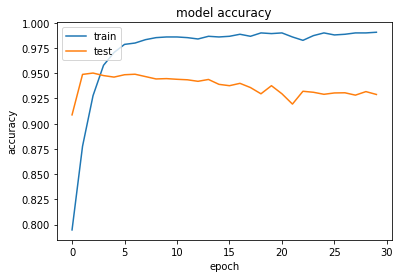

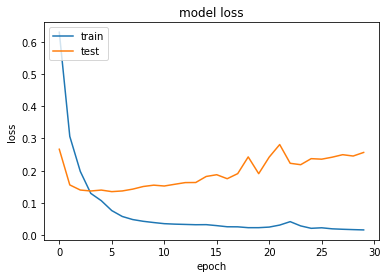

In [24]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
#Evaluation

y_true = []

yhat_class = model.predict_classes(X_val)
yhat = model.predict(X_val, verbose = 2, batch_size = batch_size)

for each in range(len(Y_val)):
    if (Y_val[each][0] == 1) & (Y_val[each][1] == 0) & (Y_val[each][2] == 0) : #negative
        y_true.append(0)
    elif (Y_val[each][0] == 0) & (Y_val[each][1] == 1) & (Y_val[each][2] == 0) : #neutral
        y_true.append(1)
    elif (Y_val[each][0] == 0) & (Y_val[each][1] == 0) & (Y_val[each][2] == 1) : #positive
        y_true.append(2)
    else:
        y_true.append(-1)

print(metrics.classification_report(y_true, yhat_class ,target_names = ["negative", "neutral","positive"]))

             precision    recall  f1-score   support

   negative       0.80      0.81      0.81       735
    neutral       0.78      0.66      0.72       260
   positive       0.81      0.85      0.83       876

avg / total       0.80      0.80      0.80      1871



Normalized confusion matrix
[[0.80680272 0.03537415 0.15782313]
 [0.11538462 0.65769231 0.22692308]
 [0.13013699 0.0239726  0.84589041]]


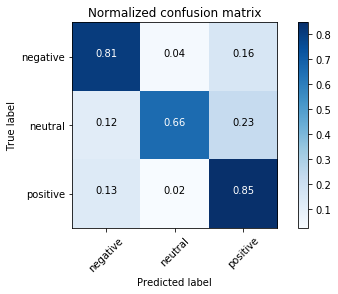

In [26]:
#Confusion Matrix

y_score = model.predict(X_val)

import itertools

score = ['negative', 'neutral','positive']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greys):
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(set(score)))
#     plt.xticks(tick_marks, score, rotation=45)
#     plt.yticks(tick_marks, score)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
    
# Compute confusion matrix
# cm = confusion_matrix(Y_val[:,1], np.round(yhat[:,1]))
# np.set_printoptions(precision=3)
# plt.figure()
# plot_confusion_matrix(cm)    

# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plt.figure()
# plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

# plt.show()

yFit_class = np.argmax(y_score, axis=1)
yVal_class = np.argmax(Y_val, axis=1)

plot_confusion_matrix(confusion_matrix(yVal_class, yFit_class, labels=[0,1,2]), 
                      classes=['negative','neutral','positive'], 
                      normalize=True,
                      title='Normalized confusion matrix')


In [27]:
#load the best model
best_model = load_model(f_chkpt_h5)

# serialize model to JSON
model_json = best_model.to_json()
with open(f_model_json, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
best_model.save_weights(f_model_weights)

In [28]:
#load old model

with open(f_model_json) as ff:
    model_json=ff.read()
    extract_model=keras.models.model_from_json(model_json)
extract_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
extract_model.load_weights(f_model_weights)

yFit = extract_model.predict(X_val, batch_size=10, verbose=1)
yFit_class = model.predict_classes(X_val)

1871/1871 [==============================] - 3s 2ms/step


In [29]:
scores = model.evaluate(X_val, Y_val, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1871/1871 [==============================] - 1s 512us/step
Accuracy: 80.44%


1871/1871 [==============================] - 1s 581us/step


| Labels\Metrics   |   Precision |   Recall |   F-Score |   Support |
|:-----------------|------------:|---------:|----------:|----------:|
| negative         |    0.812329 | 0.806803 |  0.809556 |       735 |
| neutral          |    0.73444  | 0.680769 |  0.706587 |       260 |
| positive         |    0.826667 | 0.849315 |  0.837838 |       876 |


Precision: 0.808218
Recall: 0.809193
F1-weight: 0.808489
F1-macro: 0.784660
F1-micro: 0.809193
Accuracy: 0.809193


Normalized confusion matrix
[[0.80680272 0.04761905 0.14557823]
 [0.13076923 0.68076923 0.18846154]
 [0.11757991 0.03310502 0.84931507]]




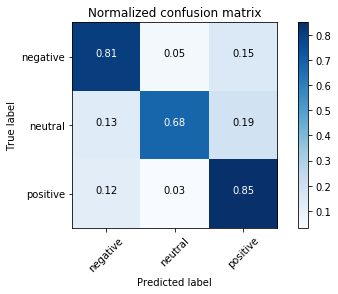

In [30]:
#sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

#more
from IPython.display import HTML, display
import tabulate
import itertools

yFit = best_model.predict(X_val, batch_size=batch_size, verbose=1)
yFit_class = np.argmax(yFit, axis=1)
yVal_class = np.argmax(Y_val, axis=1)

precision, recall, fscore, support = score(yVal_class, yFit_class, 
                                           average=None,labels = [0, 1, 2])

table = [['negative',precision[0],recall[0],fscore[0],support[0]],
['neutral',precision[1],recall[1],fscore[1],support[1]],
['positive',precision[2],recall[2],fscore[2],support[2]]]

#display(HTML(tabulate.tabulate(table, tablefmt='html', headers=['Labels\Metrics','Precision', 'Recall', 'F-Score', 'Support'])))
print("\n")
print(tabulate.tabulate(table, tablefmt='pipe', headers=['Labels\Metrics','Precision', 'Recall', 'F-Score', 'Support']))

print("\n")
w_precision = format(precision_score(yVal_class, yFit_class, average='weighted'),'.6f')
w_recall = format(recall_score(yVal_class, yFit_class, average='weighted'),'.6f')
w_fscore = format(f1_score(yVal_class, yFit_class, average='weighted'),'.6f')
ma_fscore = format(f1_score(yVal_class, yFit_class, average='macro'),'.6f')
mi_fscore = format(f1_score(yVal_class, yFit_class, average='micro'),'.6f')
w_accuracy = format(accuracy_score(yVal_class, yFit_class, normalize=True),'.6f')
#w_roc = format(roc_auc_score(yVal_class, yFit_class, average='weighted'),'.6f')
print("Precision: %s" % w_precision)
print("Recall: %s" % w_recall)
print("F1-weight: %s" % w_fscore)
print("F1-macro: %s" % ma_fscore)
print("F1-micro: %s" % mi_fscore)
print("Accuracy: %s" % w_accuracy)

print("\n")
#plt.figure()
plot_confusion_matrix(confusion_matrix(yVal_class, yFit_class, labels=[0,1,2]), 
                      classes=['negative','neutral','positive'], 
                      normalize=True,
                      title='Normalized confusion matrix')


print("\n")
display(HTML(tabulate.tabulate(table, tablefmt='latex', headers=['Labels\Metrics','Precision', 'Recall', 'F-Score', 'Support'])))
